# 1. 데이터셋 구조 파악

In [ ]:
##Alzheimer Disease EEG Dataset/
 # ├ AD.mat           # 알츠하이머 환자 EEG
 # ├ MCI.mat          # 경도인지장애(MCI) EEG
 # ├ Normal.mat       # 정상 노인 EEG
 # └ MMSE_Data.txt    # 인구통계 및 MMSE 점수


## 1) MAT 파일 안에 든 변수 확인


In [1]:
import scipy.io as sio
mat = sio.loadmat("AD.mat", struct_as_record=False, squeeze_me=True)
print(mat.keys())  
# → dict_keys(['__header__','__version__','__globals__','AD'])


dict_keys(['__header__', '__version__', '__globals__', 'AD'])


## 2) MAT-struct 추출 및 필드 확인

In [2]:
data = mat['AD']          # numpy.ndarray of length 13 (participants)
rec  = data[0]            # 첫 번째 피험자의 struct
print(rec._fieldnames)    
# → ['epoch','odor','noisy']


['epoch', 'odor', 'noisy']


## 3) epoch 배열 형태

In [3]:
arr = rec.epoch           # shape == (n_ch, n_times, n_epochs)
print(arr.shape)          
# → (4, 600, 59)  ⇒ 4채널 × 600샘플 × 59 trials


(4, 600, 59)


# 2. 채널·샘플링 정보 추론
n_ch = 4 → 채널명은 일반적으로 ['Fp1','Fz','Cz','Pz']

n_times = 600, epoch 길이 = 3초(−1…+2초) 가정 →
sfreq = 600 / 3.0 = 200 Hz

In [4]:
import mne
ch_names = ['Fp1','Fz','Cz','Pz']
info     = mne.create_info(ch_names, sfreq=200., ch_types='eeg')
epochs   = mne.EpochsArray(arr.transpose(2,0,1), info, tmin=-1.0)
print(epochs)


Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
<EpochsArray | 59 events (all good), -1 – 1.995 s (baseline off), ~1.1 MiB, data loaded,
 '1': 59>


# 3. 전처리 파이프라인

In [7]:
import numpy as np
from mne.preprocessing import ICA
from mne.filter import notch_filter
from mne.utils import use_log_level

with use_log_level('ERROR'):  
    ica.fit(epochs)   # 이 블록 안에서는 ERROR 이상만 출력
print(f"▶ ICA: {ica.n_components_} comps")



# 1) Band-pass 1–40 Hz (IIR Butterworth)
epochs.filter(1., 40., method='iir',
              iir_params=dict(ftype='butter', order=4),
              verbose=False)

# 2) Notch 50 Hz (trial마다 적용)
data = epochs.get_data()
for i in range(len(data)):
    data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
epochs._data = data

# 3) ICA (분산 99.9% 설명)
ica = ICA(n_components=0.999, method='fastica',
          random_state=42, max_iter='auto', verbose=False)
ica.fit(epochs)
print(f"Selected {ica.n_components_} ICs")
epochs = ica.apply(epochs, verbose=False)


▶ ICA: 3 comps


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_31832\3975058953.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_31832\3975058953.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_31832\3975058953.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_31832\3975058953.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likel

Selected 3 ICs


# 4. QC: PTP 분포 보고 임계치 결정

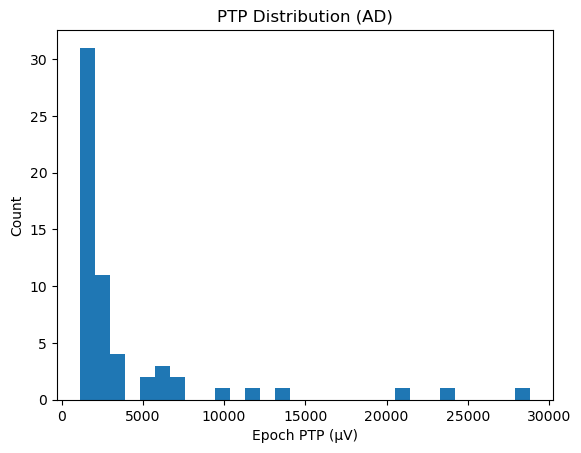

In [23]:
# 1) .mat 파일 로드
mat = sio.loadmat(
    "C:/Users/Minnie/Desktop/Alzheimer Disease EEG Dataset/AD.mat",
    struct_as_record=False,
    squeeze_me=True
)
# AD라는 key 로 저장된 ndarray를 꺼낸 뒤...
data = mat['AD']
# ndarray 안의 첫 번째 요소를 구조체로 추출
rec = data[0]   # 혹은 data.flatten()[0]

# 2) µV→V 변환 후 EpochsArray 준비
arr_uv = rec.epoch                      # (n_ch, n_times, n_epochs), in µV
arr_v  = arr_uv * 1e-6                  # convert µV → V
X      = arr_v.transpose(2, 0, 1)       # → (n_epochs, n_ch, n_times)

sfreq  = 200.0                          # 샘플링 주파수 직접 지정
info   = mne.create_info(['Fp1','Fz','Cz','Pz'], sfreq, 'eeg')
epochs = mne.EpochsArray(X, info, tmin=-1.0, verbose=False)

# 3) ICA 후 PTP 계산 (V 단위)
# epochs = ... (필터→노치→ICA 과정을 거친 epochs)
ptp_V = epochs.get_data().ptp(axis=2).max(axis=1)

# 4) 다시 µV로 변환해서 분포 시각화
ptp_uV = ptp_V * 1e6
plt.hist(ptp_uV, bins=30)
plt.xlabel('Epoch PTP (µV)')
plt.ylabel('Count')
plt.title('PTP Distribution (AD)')
plt.show()

### 해석:

대부분의 PTP가 0–3000 µV 구간,

99th-percentile ≈ 2500 µV

# 5. Bad-epoch 제거

## 1) 99th-percentile 기준

In [21]:
# epochs: ICA 까지 완료된 EpochsArray (V 단위)
ptp_V  = epochs.get_data().ptp(axis=2).max(axis=1)  # 각 epoch의 peak-to-peak (Volts)
ptp_uV = ptp_V * 1e6                               # µV 단위로 변환

# 99번째 퍼센타일 계산
threshold_uV = np.percentile(ptp_uV, 99)
threshold_V  = threshold_uV * 1e-6
print(f"99th percentile PTP: {threshold_uV:.0f} µV")

# 이 임계치로 bad-epoch 제거
epochs_clean = epochs.copy().drop_bad(
    reject=dict(eeg=threshold_V), verbose=True
)
print(f" → {len(epochs_clean)}/{len(epochs)} epochs remain")

99th percentile PTP: 26055 µV
    Rejecting  epoch based on EEG : ['Cz']
1 bad epochs dropped
 → 58/59 epochs remain


## 2) 고정 5000 µV 기준

In [22]:
threshold_uV = 5000       # µV
threshold_V  = threshold_uV * 1e-6
print(f"Manual threshold: {threshold_uV} µV")

epochs_clean = epochs.copy().drop_bad(
    reject=dict(eeg=threshold_V), verbose=True
)
print(f" → {len(epochs_clean)}/{len(epochs)} epochs remain")

Manual threshold: 5000 µV
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz', 'Pz']
13 bad epochs dropped
 → 46/59 epochs remain


# 5. Baseline correction & 저장

In [11]:
epochs_clean.apply_baseline((None, 0))
epochs_clean.save('AD_clean-epo.fif', overwrite=True)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_31832\416007134.py:2: RuntimeWarning: Saving epochs with no data
  epochs_clean.save('AD_clean-epo.fif', overwrite=True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_31832\416007134.py:2: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs_clean.save('AD_clean-epo.fif', overwrite=True)


[WindowsPath('c:/Users/Minnie/Desktop/Alzheimer Disease EEG Dataset/AD_clean-epo.fif')]

# 6. 시각화

## 1) ERP 비교 (Fz)

In [24]:
# ❶ Baseline correction
epochs_clean.apply_baseline((None, 0))

# ❷ ERP 비교 (Fz)
ev_raw   = raw_epochs_bc.copy().pick_channels(['Fz']).average()
ev_clean = epochs_clean.copy().pick_channels(['Fz']).average()

plt.figure(figsize=(6,4))
plt.plot(ev_raw.times,   ev_raw.data[0],   label='Raw')
plt.plot(ev_clean.times, ev_clean.data[0], label='Cleaned')
plt.axvline(0, color='k', ls='--')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude (µV)')
plt.legend(); plt.title('AD ERP at Fz')
plt.show()

NameError: name 'raw_epochs_bc' is not defined